In [2]:
import pandas as pd
import numpy as np
import sqlite3
import re


df = pd.read_csv("Reviews.csv", index_col=0)

print(f"Total Reviews: {len(df):,}")
print(f"Columns: {list(df.columns)}")
print(df.head())
print(df.isnull().sum())   
print(df.describe())       

Total Reviews: 23,486
Columns: ['Clothing ID', 'Age', 'Title', 'Review Text', 'Rating', 'Recommended IND', 'Positive Feedback Count', 'Division Name', 'Department Name', 'Class Name']
   Clothing ID  Age                    Title  \
0          767   33                      NaN   
1         1080   34                      NaN   
2         1077   60  Some major design flaws   
3         1049   50         My favorite buy!   
4          847   47         Flattering shirt   

                                         Review Text  Rating  Recommended IND  \
0  Absolutely wonderful - silky and sexy and comf...       4                1   
1  Love this dress!  it's sooo pretty.  i happene...       5                1   
2  I had such high hopes for this dress and reall...       3                0   
3  I love, love, love this jumpsuit. it's fun, fl...       5                1   
4  This shirt is very flattering to all due to th...       5                1   

   Positive Feedback Count   Division Na

In [3]:

df.columns = df.columns.str.strip().str.replace(' ', '_').str.lower()


df = df.dropna(subset=['review_text'])

df['title']           = df['title'].fillna('No Title')
df['division_name']   = df['division_name'].fillna('Unknown')
df['department_name'] = df['department_name'].fillna('Unknown')
df['class_name']      = df['class_name'].fillna('Unknown')
df['age']             = df['age'].fillna(df['age'].median())


df = df.drop_duplicates()
print(f" Clean dataset: {len(df):,} reviews")

 Clean dataset: 22,640 reviews


In [4]:

def assign_sentiment(rating):
    if rating >= 4:   return 'Positive'
    elif rating == 3: return 'Neutral'
    else:             return 'Negative'

df['sentiment'] = df['rating'].apply(assign_sentiment)
df['sentiment_label'] = df['sentiment'].map({'Positive':1,'Neutral':0,'Negative':-1})

print(df['sentiment'].value_counts())

sentiment
Positive    17447
Neutral      2823
Negative     2370
Name: count, dtype: int64


In [5]:
def clean_text(text):
    if pd.isna(text): return ""
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  
    text = re.sub(r'\s+', ' ', text).strip()  
    return text

df['cleaned_review'] = df['review_text'].apply(clean_text)
df['word_count']     = df['review_text'].apply(lambda x: len(str(x).split()))
df['review_length']  = df['review_text'].apply(len)

print(f"Avg word count: {df['word_count'].mean():.0f} words")

Avg word count: 60 words


In [6]:
conn = sqlite3.connect('sentiment_analysis.db')


df.to_sql('reviews', conn, if_exists='replace', index=False)

summary = pd.DataFrame({
    'metric': ['total','positive','neutral','negative','avg_rating'],
    'value':  [len(df),
               len(df[df['sentiment']=='Positive']),
               len(df[df['sentiment']=='Neutral']),
               len(df[df['sentiment']=='Negative']),
               round(df['rating'].mean(), 2)]
})
summary.to_sql('summary', conn, if_exists='replace', index=False)
print("Database saved: sentiment_analysis.db")

Database saved: sentiment_analysis.db


In [7]:
# Sentiment breakdown
q1 = pd.read_sql_query("""
    SELECT sentiment,
           COUNT(*) as count,
           ROUND(COUNT(*)*100.0/(SELECT COUNT(*) FROM reviews),2) as pct
    FROM reviews
    GROUP BY sentiment
    ORDER BY count DESC
""", conn)
print(q1)

#Avg rating by department
q2 = pd.read_sql_query("""
    SELECT department_name,
           COUNT(*) as reviews,
           ROUND(AVG(rating),2) as avg_rating
    FROM reviews
    GROUP BY department_name
    ORDER BY avg_rating DESC
""", conn)
print(q2)

conn.close()

  sentiment  count    pct
0  Positive  17447  77.06
1   Neutral   2823  12.47
2  Negative   2370  10.47
  department_name  reviews  avg_rating
0         Unknown       13        5.00
1         Bottoms     3661        4.28
2        Intimate     1653        4.27
3         Jackets     1002        4.25
4            Tops    10048        4.16
5         Dresses     6145        4.14
6           Trend      118        3.84


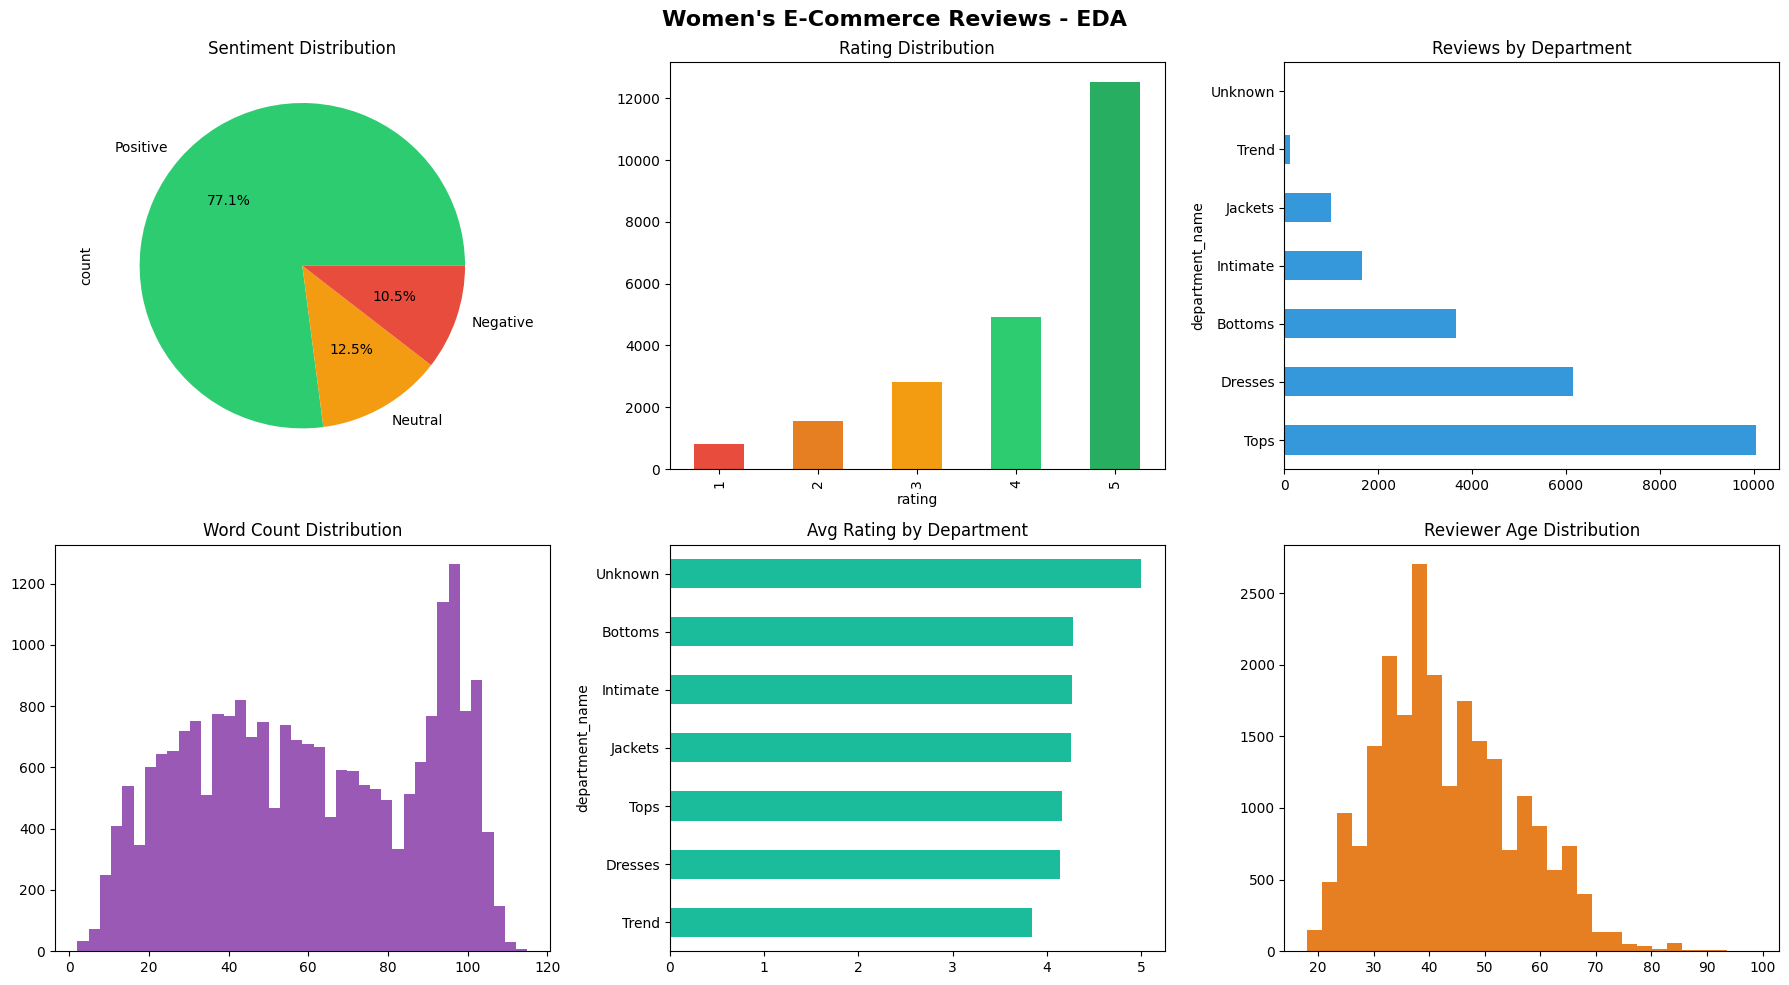

 Chart saved: eda_visualizations.png


In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("Women's E-Commerce Reviews - EDA", fontsize=16, fontweight='bold')

# Sentiment pie chart
df['sentiment'].value_counts().plot(
    kind='pie', ax=axes[0,0], autopct='%1.1f%%',
    colors=['#2ecc71','#f39c12','#e74c3c'])
axes[0,0].set_title('Sentiment Distribution')

# Rating bar chart
df['rating'].value_counts().sort_index().plot(
    kind='bar', ax=axes[0,1],
    color=['#e74c3c','#e67e22','#f39c12','#2ecc71','#27ae60'])
axes[0,1].set_title('Rating Distribution')

# Reviews by department
df['department_name'].value_counts().plot(
    kind='barh', ax=axes[0,2], color='#3498db')
axes[0,2].set_title('Reviews by Department')

# Word count histogram
axes[1,0].hist(df['word_count'], bins=40, color='#9b59b6')
axes[1,0].set_title('Word Count Distribution')

# Avg rating by department
df.groupby('department_name')['rating'].mean().sort_values().plot(
    kind='barh', ax=axes[1,1], color='#1abc9c')
axes[1,1].set_title('Avg Rating by Department')

# Age distribution
axes[1,2].hist(df['age'], bins=30, color='#e67e22')
axes[1,2].set_title('Reviewer Age Distribution')

plt.tight_layout()
plt.savefig('eda_visualizations.png', dpi=150)
plt.show()
print(" Chart saved: eda_visualizations.png")

In [10]:
df.to_csv('cleaned_reviews.csv', index=False)
print("Saved: cleaned_reviews.csv")

Saved: cleaned_reviews.csv
